In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
print("tensorflow2 version:", tf.__version__)
print("numpy version:",np.__version__)
print("matplotlib version:",matplotlib.__version__)
print("python",sys.version[:6])

tensorflow2 version: 2.4.1
numpy version: 1.19.5
matplotlib version: 3.3.3
python 3.8.5 


In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape([60000,28,28,1])
test_images = test_images.reshape([10000,28,28, 1])

In [3]:
IMG_SIZE = 32
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    resize_and_rescale = tf.keras.Sequential([
      layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
      layers.experimental.preprocessing.Rescaling(1./255)
    ])

train_images = np.array([resize_and_rescale(img) for img in train_images])
test_images = np.array([resize_and_rescale(img) for img in test_images])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [4]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    
    n_kernel_lst = [64, 128, 256, 256, 512, 512, 512, 512]
    max_pool_layer_lst = [0, 1, 3, 5, 7]
    model = models.Sequential()

    for layer_idx, n_kernel in enumerate(n_kernel_lst):
        if layer_idx == 0:
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    input_shape=(32, 32, 1), padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation('relu'))
        else:        
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                     padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation('relu'))
        if layer_idx in max_pool_layer_lst:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
model.summary()    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=5, batch_size = 256, shuffle=True, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
235/235 [==============================] - 34s 110ms/step - loss: 1.9312 - accuracy: 0.4580 - val_loss: 8.4588 - val_accuracy: 0.1181
Epoch 2/5
235/235 [==============================] - 24s 101ms/step - loss: 0.0935 - accuracy: 0.9751 - val_loss: 0.1178 - val_accuracy: 0.9644
Epoch 3/5
235/235 [==============================] - 24s 101ms/step - loss: 0.0580 - accuracy: 0.9860 - val_loss: 0.0454 - val_accuracy: 0.9876
Epoch 4/5
235/235 [==============================] - 24s 101ms/step - loss: 0.0501 - accuracy: 0.9866 - val_loss: 0.0483 - val_accuracy: 0.9878
Epoch 5/5
235/235 [==============================] - 24s 101ms/step - loss: 0.0364 - accuracy: 0.9908 - val_loss: 0.1343 - val_accuracy: 0.9623


Text(0.5, 1.0, 'accuracy vs epoch')

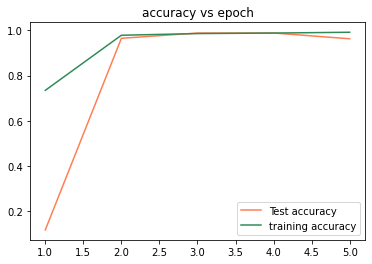

In [6]:
x_ax = [1,2,3,4,5]
plt.plot(x_ax, history.history['val_accuracy'], label='Test accuracy', color="coral")
plt.plot(x_ax, history.history['accuracy'], label='training accuracy', color="seagreen")
plt.legend()
plt.title('accuracy vs epoch')

Text(0.5, 1.0, 'loss vs epoch')

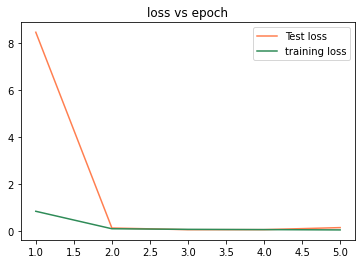

In [7]:
plt.plot(x_ax, history.history['val_loss'], label='Test loss', color="coral")
plt.plot(x_ax, history.history['loss'], label='training loss', color="seagreen")
plt.legend()
plt.title('loss vs epoch')

In [8]:
np.flip(train_images, 1).shape

(60000, 32, 32, 1)

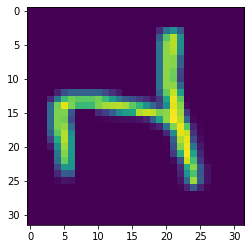

In [9]:
# flip from top to bottom
plt.imshow(tf.experimental.numpy.flip(train_images, 1)[2])

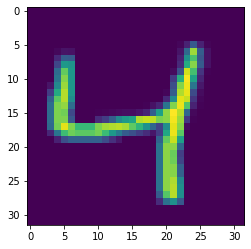

In [10]:
plt.imshow(train_images[2])

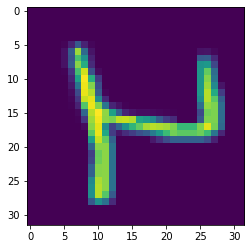

In [11]:
# flip from left to right
plt.imshow(tf.experimental.numpy.flip(train_images, 2)[2])

In [12]:
y_pred = model.predict(test_images)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9623

In [13]:
# flip from left to right
ir_test_img = np.flip(test_images, 2)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.3733

In [14]:
# flip from top to bottom
ir_test_img = np.flip(test_images, 1)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.4119

In [15]:
lst_sigma = [0.01, 0.1, 1]
test_set_shape = test_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=test_set_shape, stddev=math.sqrt(sigma))
    y_pred = model.predict(test_images+noise)
    scce = tf.keras.metrics.Accuracy()
    print(scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy())

0.8774
0.5673
0.1712


In [16]:
train_images_aug = np.concatenate([train_images, np.flip(train_images, 1), np.flip(train_images, 2)])
train_labels_aug = np.concatenate([train_labels, train_labels, train_labels])

In [17]:
lst_sigma = [0.01, 0.1, 1]
train_set_shape = train_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=train_set_shape, stddev=math.sqrt(sigma))
    train_images_aug = np.concatenate([train_images_aug, train_images+noise])
    train_labels_aug = np.concatenate([train_labels_aug, train_labels])

In [18]:
train_images_aug.shape

(360000, 32, 32, 1)

In [19]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    
    n_kernel_lst = [64, 128, 256, 256, 512, 512, 512, 512]
    max_pool_layer_lst = [0, 1, 3, 5, 7]
    model = models.Sequential()

    for layer_idx, n_kernel in enumerate(n_kernel_lst):
        if layer_idx == 0:
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    input_shape=(32, 32, 1), padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation('relu'))
        else:        
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                     padding='same'))
            model.add(layers.BatchNormalization())
            model.add(layers.Activation('relu'))
        if layer_idx in max_pool_layer_lst:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
model.summary()    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_10 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 1

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(train_images_aug, train_labels_aug, epochs=5, batch_size = 256, shuffle=True, 
                    validation_data=(test_images, test_labels))

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
1407/1407 [==============================] - 144s 99ms/step - loss: 1.2435 - accuracy: 0.5612 - val_loss: 0.1445 - val_accuracy: 0.9560
Epoch 2/5
1407/1407 [==============================] - 137s 98ms/step - loss: 0.1602 - accuracy: 0.9552 - val_loss: 0.1521 - val_accuracy: 0.9553
Epoch 3/5
1407/1407 [==============================] - 137s 98ms/step - loss: 0.1218 - accuracy: 0.9655 - val_loss: 0.0608 - val_accuracy: 0.9829
Epoch 4/5
1407/1407 [==============================] - 137s 97ms/step - loss: 0.1006 - accuracy: 0.9708 - val_loss: 0.0462 - val_accuracy: 0.9870
Epoch 5/5
1407/1407 [==============================] - 137s 97ms/step - loss: 0.0844 - accuracy: 0.9754 - val_loss: 0.0309 - val_accuracy: 0.9901


In [21]:
# flip from left to right
ir_test_img = np.flip(test_images, 2)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9892

In [22]:
# flip from top to bottom
ir_test_img = np.flip(test_images, 1)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9732

In [23]:
lst_sigma = [0.01, 0.1, 1]
test_set_shape = test_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=test_set_shape, stddev=math.sqrt(sigma))
    y_pred = model.predict(test_images+noise)
    scce = tf.keras.metrics.Accuracy()
    print(scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy())

0.9928
0.9892
0.8747


In [24]:
y_pred = model.predict(test_images)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9898